# Deterministic methods

## Point estimates

If we just want to find the parameter value that maximizes the posterior probability, we can just use numerical optimization over $p(y \mid \theta)p(\theta)$. The value found is known as the Maximum a Posteriori (or MAP), and is the Bayesian counterpart of the Maximum Likelihood Estimate (MLE). However, a point estimate gives relatively little information and may be highly misleading, and hence we are usually interested in estimating the full posterior distribution. 

As we have seen, MCMC is one method for estimating the posterior. However, MCMC is relatively slow, and an alternative is to use deterministic Variational Inference (VI) methods which are usually much faster. The trade-off is that VI methods can only find an approximation of the true posterior, and the approximation may not be very good. 

## Laplace approximation

The basic idea is to use a Gaussian $N(\mu, \Sigma)$ centered at the mode of the log posterior distribution as an approximation. This can be done by first finding the mode using numerical optimization and using that for $\mu$, then estimating the covariance as the inverse of the Hessian at the mode.

Note that for a Gaussian, the negative log likelihood basically has the form $a + b + \frac{1}{2}x^T A x$ where $A = \Sigma^{-1}$ and $a, b$ are terms that don't depend on $x$. By differentiating, we get that the Hessian is the inverse covariance matrix.

Notes and illustrations in class.

## Entropy

$$
H(p) = -\sum_{i} p_i \log(p_i)
$$

In [8]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [19]:
import scipy.stats as stats

In [2]:
def entropy(p):
    """Calculate entropy."""
    return -np.sum(p * np.log(p))

In [31]:
for σ in 1, 10, 100:
    print('N(1, %3d) entropy = %.2f' % (σ, stats.norm(0, σ).entropy()))

N(1,   1) entropy = 1.42
N(1,  10) entropy = 3.72
N(1, 100) entropy = 6.02


## Kullback-Leibler divergence (relative entropy)

$$
D_{\text{KL}}(p \vert\vert q) = \sum_i p_i \log \frac{p_i}{q_i}
$$

In the usual interpretation, $p$ is the true distribution (e.g. posterior probability), and $q$ is an approximation (e.g. prior probability). $D_{\text{KL}}(p \vert\vert q)$ is a measure of how well $q$ approximates $p$, and hence is usually read as the Kullback Leibler divergence from $q$ to $p$.

Properties of  $D_{\text{KL}}(p \vert\vert q)$

- non-negative (e.g. use Jensen's inequality)
$$
D_{\text{KL}}(p \vert\vert q) = \sum_i p_i \log \frac{p_i}{q_i} =  -\sum_i p_i \log \frac{q_i}{p_i} \ge -\log\sum_i p_i  \frac{q_i}{p_i} = 0
$$
- equal to zero only if $p = q$ almost everywhere
- invariant under parameter transforms
- Suppose $p(x) = p_1(x) p_2(x)$ and $q(x) = q_1(x) q_2(x)$, then 
$$D_{\text{KL}}(p \vert\vert q) = D_{\text{KL}}(p_1 \vert\vert q_1) + D_{\text{KL}}(p_2 \vert\vert q_2)$$

Note:

- If $p_i = 0$ then $i$ contributes 0 to DKL
- If $q_i = 0$ and $p_i = 0$, then $i$ contributes 0 to DKL
- If $q_i = 0$ and $p_i \ne 0$, then DKL is undefined.

In [50]:
xs = np.random.poisson(5, 1000)

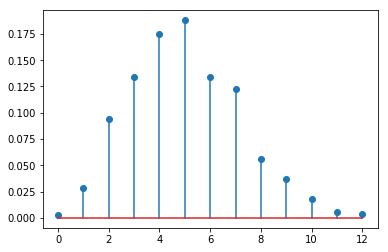

In [51]:
ys = np.bincount(xs)
ys = ys/ys.sum()
plt.stem(ys)
pass

In [52]:
r = np.arange(len(ys))

In [53]:
r

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

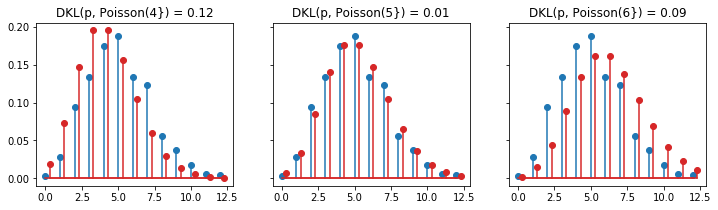

In [69]:
fig, axes = plt.subplots(1,3,figsize=(12,3), sharey=True)
for ax, λ in zip(axes, (4, 5,6)):
    ax.stem(ys)
    ax.stem(r+0.3, stats.poisson(λ).pmf(r), linefmt='C3-', markerfmt='C3o')
    ax.set_title('DKL(p, Poisson(%d}) = %.2f' % (λ, stats.entropy(ys, stats.poisson(λ).pmf(r))))

## Evidence lower bound (ELBO)

We want to approximate the posterior distribution $p(\theta \mid y)$ with $q(\theta)$. In the usual approach, we want to minimize 

\begin{array}
\\
D_{\text{KL}}(q(\theta) \vert\vert p(\theta | y)) &= \int q(\theta) \log \frac{q(\theta)}{p(\theta \mid y)} \ d\theta \\
&= \int q(\theta) \log \frac{q(\theta)}{p(\theta, y)}p(y) \ d\theta \\
&= \int q(\theta) \left( \log \frac{q(\theta)}{p(\theta, y)} + \log p(y) \right) \ d\theta \\
&= \int q(\theta)  \log \frac{q(\theta)}{p(\theta, y)} \ d\theta + \int q(\theta) \log p(y) \ d\theta \\
&= - \int q(\theta) \log \frac{p(\theta, y)}{q(\theta)} \ d\theta + \log p(y)
\end{array}

Since the Kullback-Leibler divergence $\ge 0$, the marginal likelihood or evidence $p(y) \ge \int q(\theta) \log \frac{p(\theta, y)}{q(\theta)} \ d\theta$ and $\int q(\theta) \log \frac{p(\theta, y)}{q(\theta)} \ d\theta$ is known as the Evidence Lower Bound (ELBO). The ELBO can also be seen as $E_q[\log p(\theta, y)] - E[\log q(\theta)]$, where the second term is the entropy (or differential entropy).

Hence if $q(\theta)$ is a family of (simple) distributions with tuning parameters $\lambda$, finding the values of $\lambda$ that maximize the ELBO is equivalent to minimizing $D_{\text{KL}}(q(\theta) \vert\vert p(\theta | y))$.

### Variational Inference with a mean field approximation

To estimate $\theta = (\theta_1, \theta_2, \ldots, \theta_n)$, the mean field approximation assumes that 

$$
q(\theta) = \prod_{i=1}^{n} q(\theta_i)
$$

The factorization gives a form of the ELBO that can be solved by numerical optimization. Note that the solution found will usually not be the true posterior, since the mean field approximations assume that the variables are independent.


![img](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/0dffe45c7df96e18d3300ce1d0f08d9debed4a38/9-Figure1-1.png)

Source: [Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)

## ADVI

The optimization is usually done with gradient information with derivatives found by automatic differentiation, and hence this family of probabilistic inference engines is known as Automatic Differentiation Variational Inference (ADVI).

For further reading, see [Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)